Imports

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    roc_curve,
    auc
)

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier






Load the dataset

In [2]:
# Get the parent directory (DS3000-Group-4) and navigate to Data
current_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results.csv')

df = pd.read_csv(data_path) # Load the dataset
df = df.drop(columns=['Exploratory', 'Timestamp', 
                      'Primary streaming service', 'BPM', 'Music effects', 'Permissions']) # Drop unnecessary columns
df = df.dropna() # Drop rows with any missing values
df.head() # Display the first few rows of the cleaned dataset

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0


Visualise distribution of genre preferences

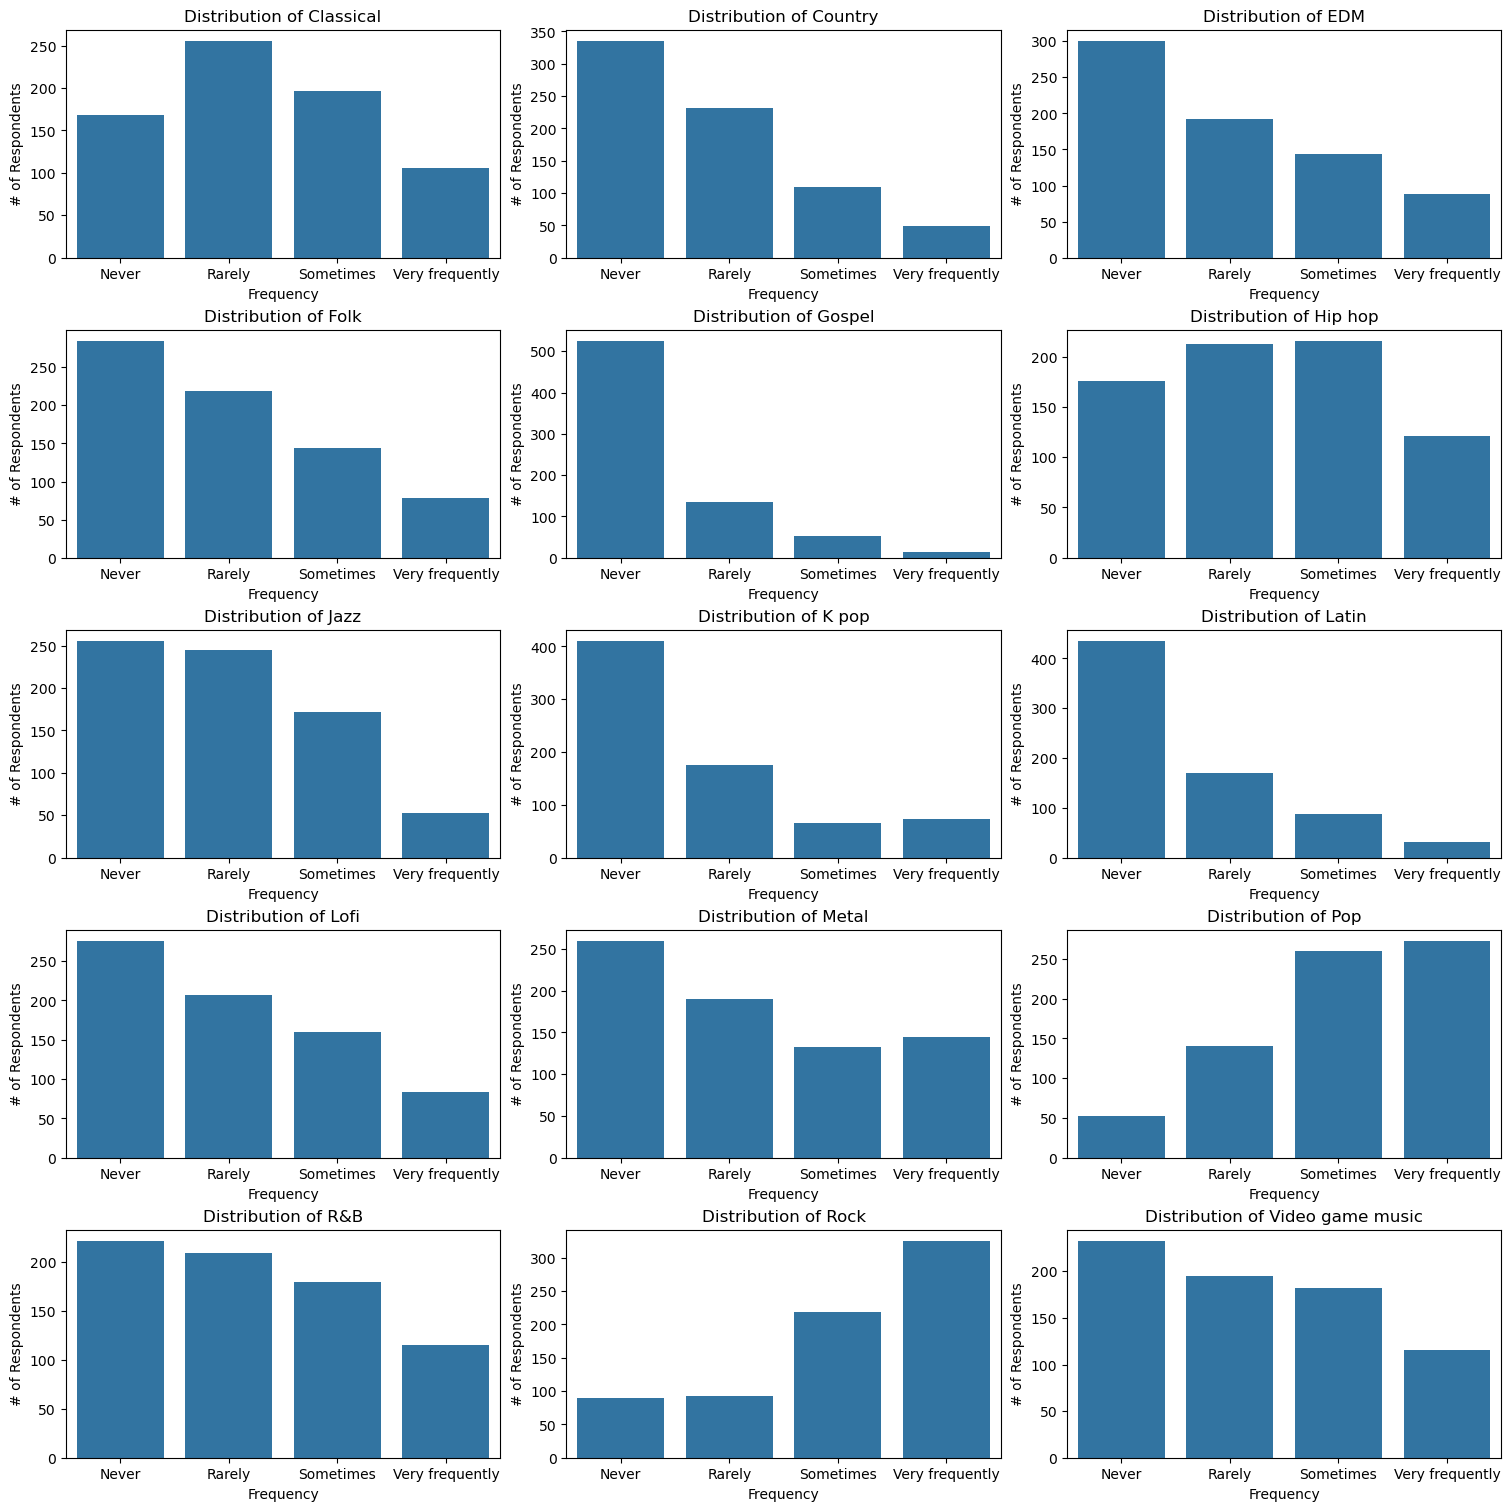

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of each genre frequency in a grid
mh_condition = ['Classical', 'Country', 'EDM', 'Folk', 'Gospel', 'Hip hop', 'Jazz', 'K pop',
                 'Latin', 'Lofi', 'Metal', 'Pop', 'R&B', 'Rock', 'Video game music']

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'Frequency [{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No genre columns found to plot")

# Frequency order
freq_order = ['Never', 'Rarely', 'Sometimes', 'Very frequently']

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    s = df[col].dropna()
    # Ensure categorical with explicit order
    s = pd.Categorical(s, categories=freq_order, ordered=True)
    sns.countplot(x=s, ax=ax, color='C0', order=freq_order)
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

In [4]:
# Drop gospel, as we do not have enough data points on those who listen to it sometimes or very frequently
df = df.drop(columns=['Frequency [Gospel]'])

Visualise dsitribution of Other Features

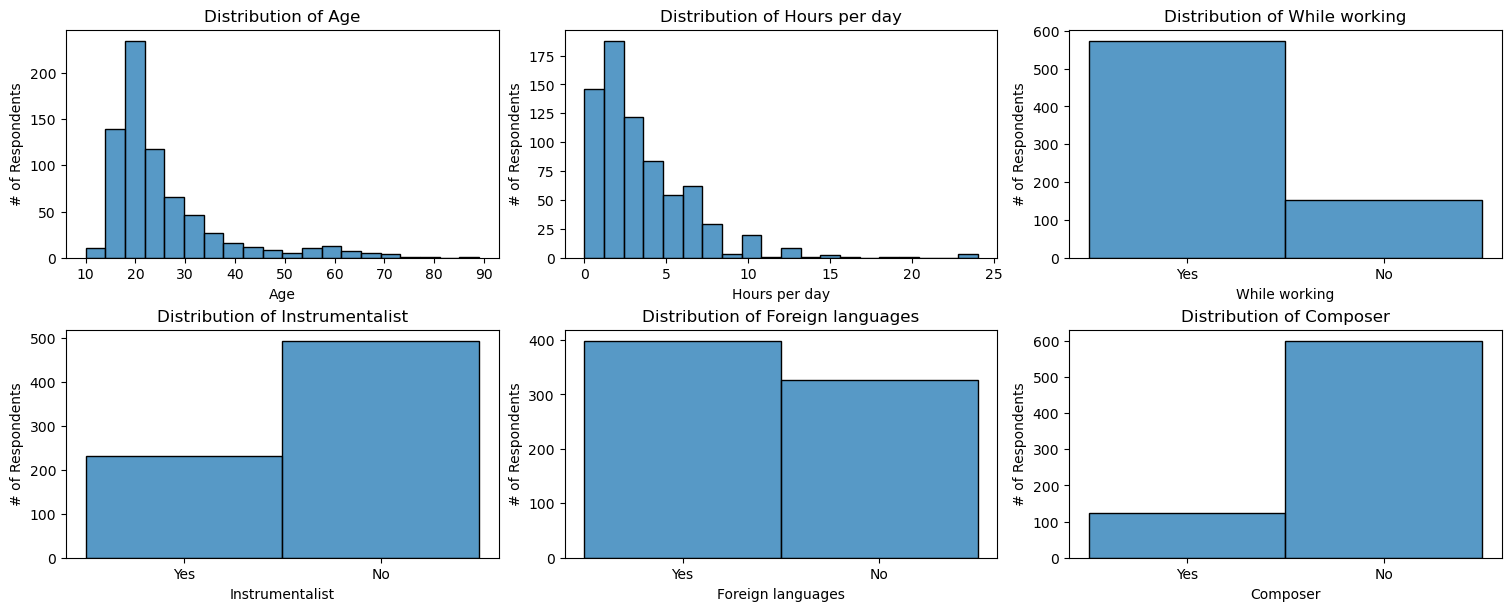

In [5]:
# Plot the distribution of Non-Genre Features
mh_condition = ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Foreign languages', 'Composer' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for feature '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No feature columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel(col)
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()    

Visualise the distribution of mental health conditions

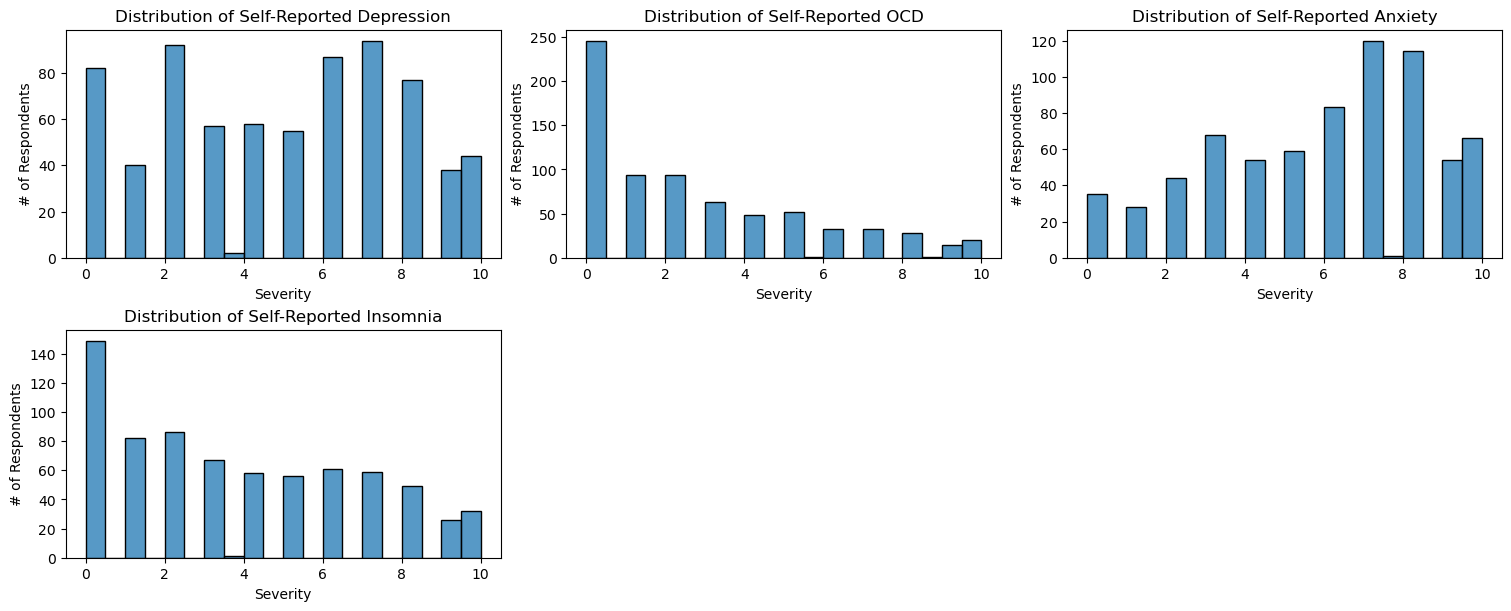

In [6]:
import math
import numpy as np

# Plot the distribution of each genre frequency in a grid
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No MH columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Severity [', '').replace(']', '')
    ax.set_title(f'Distribution of Self-Reported {title}')
    ax.set_xlabel('Severity')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

We see that we do not have many respondants reporting symptoms of OCD. Therefore, we may not be able to accurately model music-factor trends relating to higher/lower levels of OCD.

We notice that most respondants experience moderate to high anxiety.

We notice that we have good balance of respondants experiencing various levels of depression. We may have more success forecasting this.

In [7]:
# Frame mental health condition columns as classification targets
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

def to_3class(score_series):
    """
    Map numeric scores to 3 classes:
    0–3  -> 0 (Low)
    4–6  -> 1 (Moderate)
    7–10 -> 2 (High)
    """
    bins = [-np.inf, 3.0, 6.0, np.inf] # Define class bin edges
    labels = [0, 1, 2] # Corresponding class labels
    return pd.cut(score_series, bins=bins, labels=labels).astype(int) # Convert to int type


# Convert target columns if they exist
target_conditions = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
for t in target_conditions:
    if t in df.columns:
        df[f"{t}_class"] = to_3class(df[t])

# Drop original target columns if they exist
existing_targets = [t for t in target_conditions if t in df.columns]
if existing_targets:
    df = df.drop(columns=existing_targets)    

df.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,0,0,0,0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,2,0,0,0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,2,2,0,0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,2,0,1,2


In [8]:
# Convert favourite genre into a boost applied to the users favourite genre frequency
import pandas as pd

# Define frequency mapping
freq_map = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Frequently": 3,
    "Very frequently": 4
}

# Copy df to avoid mutating original
df_fe = df.copy()

# Identify genre frequency columns
freq_cols = [col for col in df.columns if col.startswith("Frequency")]


# Convert frequency columns to numeric using the mapping
for col in freq_cols:
    df_fe[col] = df_fe[col].map(freq_map).astype(float)


# Create a normalised genre name lookup so "Fav genre" matches frequency column names
# Example: "Rock" → "Frequency [Rock]"
def genre_to_freq_column(genre):
    return f"Frequency [{genre}]"

BOOST_AMOUNT = 1.0   # You may tune this later

def convert_fav_genre_to_freq_col(genre):
    """Convert 'Rock' → 'Frequency [Rock]'."""
    return f"Frequency [{genre}]"

for idx, row in df_fe.iterrows():
    fav = row["Fav genre"]
    target_col = convert_fav_genre_to_freq_col(fav)

    if target_col in freq_cols:
        df_fe.loc[idx, target_col] = df_fe.loc[idx, target_col] + BOOST_AMOUNT

# Drop original Fav genre column if model should not see it
df_fe = df_fe.drop(columns=["Fav genre"])

# Display the processed dataframe
df_fe.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Yes,1.0,0.0,1.0,0.0,...,0.0,4.0,2.0,4.0,0.0,2.0,0,0,0,0
1,63.0,1.5,Yes,No,No,No,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,1.0,5.0,1.0,2,0,0,0
2,18.0,4.0,No,No,No,Yes,0.0,0.0,4.0,0.0,...,2.0,1.0,0.0,1.0,1.0,5.0,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Yes,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,0.0,0.0,0.0,2,2,0,0
4,18.0,4.0,Yes,No,No,No,0.0,0.0,1.0,0.0,...,0.0,2.0,5.0,4.0,0.0,1.0,2,0,1,2


In [9]:
# Start from a clean copy of the original dataframe
df_fe1 = df_fe.copy()

# Clean col names to avoid key errors
df_fe1.columns = (
    df_fe1.columns.astype(str)
    .str.strip()
    .str.replace('\xa0', '', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
)

print("Cleaned column names:", df_fe1.columns.tolist())

# Define age group bins and labels
age_bins = [0, 17, 25, 35, 45, 55, 65, np.inf]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

if 'Age' not in df_fe1.columns:
    raise KeyError("'Age' column not found in dataframe.")

# Create Age Group categorical feature
df_fe1['Age Group'] = pd.cut(
    df_fe1['Age'], bins=age_bins, labels=age_labels
)

# One-hot encode Age Group (categorical, not ordinal!)
df_fe1 = pd.get_dummies(df_fe1, columns=['Age Group'], prefix='AgeGroup')

# Drop the original Age column if not needed
df_fe1 = df_fe1.drop(columns=['Age'])

# AUTO-DETECT YES/NO COLUMNS
yes_no_cols = []
for col in df_fe1.columns:
    nonnull = df_fe1[col].dropna().unique()
    if len(nonnull) > 0 and set(nonnull).issubset({'Yes', 'No'}):
        yes_no_cols.append(col)
    if len(nonnull) > 0 and set(nonnull).issubset({'True', 'False'}):
        yes_no_cols.append(col)

print("Detected Yes/No columns:", yes_no_cols)

# Convert boolean to binary 1/0
for col in yes_no_cols:
    df_fe1[col] = df_fe1[col].map({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})

df_fe1.head(10) # Display the first 10 rows of the final feature-engineered dataframe


Cleaned column names: ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer', 'Foreign languages', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]', 'Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']
Detected Yes/No columns: ['While working', 'Instrumentalist', 'Composer', 'Foreign languages']


,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Hip hop],...,Depression_class,Insomnia_class,OCD_class,AgeGroup_<18,AgeGroup_18-24,AgeGroup_25-34,AgeGroup_35-44,AgeGroup_45-54,AgeGroup_55-64,AgeGroup_65+
0,3.0,1,1,1,1,1.0,0.0,1.0,0.0,2.0,...,0,0,0,False,True,False,False,False,False,False
1,1.5,1,0,0,0,2.0,0.0,0.0,1.0,1.0,...,0,0,0,False,False,False,False,False,True,False
2,4.0,0,0,0,1,0.0,0.0,4.0,0.0,1.0,...,2,2,0,False,True,False,False,False,False,False
3,2.5,1,0,1,1,2.0,0.0,0.0,1.0,0.0,...,2,0,0,False,False,False,False,False,True,False
4,4.0,1,0,0,0,0.0,0.0,1.0,0.0,4.0,...,0,1,2,False,True,False,False,False,False,False
5,5.0,1,1,1,1,1.0,2.0,0.0,0.0,2.0,...,2,2,2,False,True,False,False,False,False,False
6,3.0,1,1,0,1,2.0,0.0,1.0,2.0,1.0,...,2,1,0,False,True,False,False,False,False,False
7,1.0,1,0,0,1,0.0,0.0,1.0,0.0,4.0,...,0,1,0,False,True,False,False,False,False,False
8,6.0,1,0,0,0,0.0,4.0,0.0,2.0,0.0,...,0,0,0,False,True,False,False,False,False,False
9,1.0,1,0,0,1,1.0,1.0,1.0,1.0,1.0,...,0,1,0,False,True,False,False,False,False,False


[I 2025-11-30 23:37:01,702] A new study created in memory with name: no-name-890d25f3-0e5f-417c-8176-e4ca0533d233
[I 2025-11-30 23:37:02,147] Trial 0 finished with value: 0.323991453778933 and parameters: {'n_estimators': 187, 'learning_rate': 0.2313074696479459, 'max_depth': 7, 'subsample': 0.9903949480829997, 'colsample_bytree': 0.9075325917531617, 'gamma': 0.8941289606118672, 'min_child_weight': 9}. Best is trial 0 with value: 0.323991453778933.
[I 2025-11-30 23:37:02,672] Trial 1 finished with value: 0.3853737644685559 and parameters: {'n_estimators': 158, 'learning_rate': 0.24881673518445488, 'max_depth': 5, 'subsample': 0.842800317172146, 'colsample_bytree': 0.8398950559238078, 'gamma': 0.12748002652070545, 'min_child_weight': 4}. Best is trial 1 with value: 0.3853737644685559.
[I 2025-11-30 23:37:03,053] Trial 2 finished with value: 0.3348983420364278 and parameters: {'n_estimators': 135, 'learning_rate': 0.07856210138974155, 'max_depth': 4, 'subsample': 0.8983438819293754, 'col

Best hyperparameters: {'n_estimators': 203, 'learning_rate': 0.14127468137277815, 'max_depth': 7, 'subsample': 0.8868868747351368, 'colsample_bytree': 0.6829918869885431, 'gamma': 0.3165576844701554, 'min_child_weight': 7}

Evaluation on test set:
Accuracy: 0.4520547945205479
Precision: 0.35745067497403943
Recall: 0.3582159624413146
F1 Score: 0.3335734030458844
ROC AUC: 0.5708694181634654

Classification report:
              precision    recall  f1-score   support

           0       0.29      0.20      0.24        35
           1       0.27      0.10      0.15        40
           2       0.51      0.77      0.62        71

    accuracy                           0.45       146
   macro avg       0.36      0.36      0.33       146
weighted avg       0.39      0.45      0.40       146



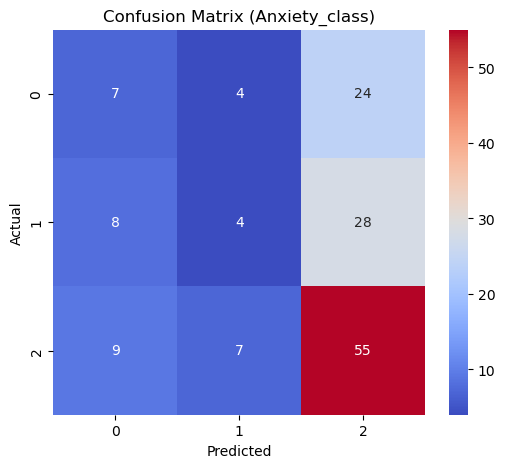

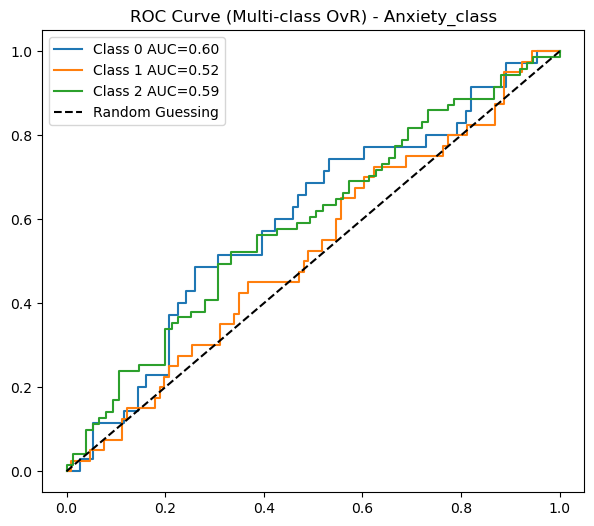

[I 2025-11-30 23:37:21,282] A new study created in memory with name: no-name-db4893db-3c43-49ec-b99a-7527359c79c0


Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_anxiety_model.pkl


[I 2025-11-30 23:37:21,929] Trial 0 finished with value: 0.3663351094125749 and parameters: {'n_estimators': 338, 'learning_rate': 0.18920633280754628, 'max_depth': 3, 'subsample': 0.8305471009198435, 'colsample_bytree': 0.9422547263684393, 'gamma': 1.987170293742439, 'min_child_weight': 1}. Best is trial 0 with value: 0.3663351094125749.
[I 2025-11-30 23:37:22,273] Trial 1 finished with value: 0.3819939161329789 and parameters: {'n_estimators': 128, 'learning_rate': 0.24018560840840547, 'max_depth': 7, 'subsample': 0.7962557875245037, 'colsample_bytree': 0.9276988511358703, 'gamma': 0.9948710862785453, 'min_child_weight': 7}. Best is trial 1 with value: 0.3819939161329789.
[I 2025-11-30 23:37:22,948] Trial 2 finished with value: 0.3775112804255394 and parameters: {'n_estimators': 249, 'learning_rate': 0.11528919387992274, 'max_depth': 5, 'subsample': 0.7763398868361923, 'colsample_bytree': 0.7091082780454391, 'gamma': 0.39149217460899344, 'min_child_weight': 6}. Best is trial 1 with v

Best hyperparameters: {'n_estimators': 394, 'learning_rate': 0.10706351690666463, 'max_depth': 4, 'subsample': 0.8091686014279014, 'colsample_bytree': 0.8642206630101001, 'gamma': 0.7160128907773606, 'min_child_weight': 4}

Evaluation on test set:
Accuracy: 0.4520547945205479
Precision: 0.4398211437685122
Recall: 0.4406982305117169
F1 Score: 0.4384945693356908
ROC AUC: 0.606022377985362

Classification report:
              precision    recall  f1-score   support

           0       0.47      0.50      0.49        54
           1       0.36      0.29      0.32        41
           2       0.48      0.53      0.50        51

    accuracy                           0.45       146
   macro avg       0.44      0.44      0.44       146
weighted avg       0.45      0.45      0.45       146



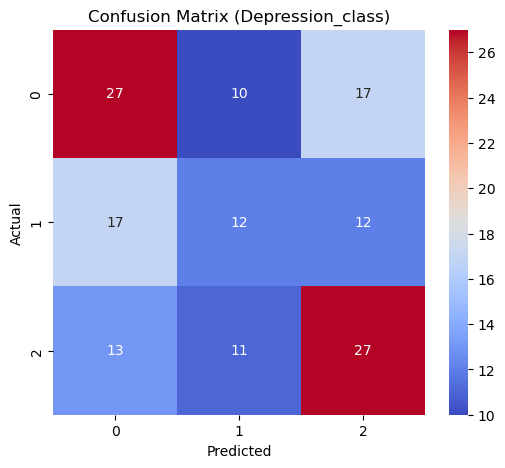

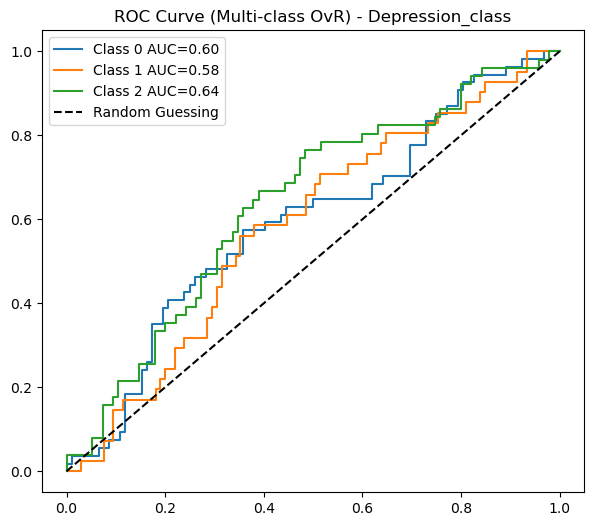

[I 2025-11-30 23:37:42,781] A new study created in memory with name: no-name-968065fb-8092-4d3f-9380-2ec1011513d5


Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_depression_model.pkl


[I 2025-11-30 23:37:43,268] Trial 0 finished with value: 0.38164185869650735 and parameters: {'n_estimators': 108, 'learning_rate': 0.10853221570631168, 'max_depth': 6, 'subsample': 0.8266193919602796, 'colsample_bytree': 0.9349242556079398, 'gamma': 0.022900326462922616, 'min_child_weight': 7}. Best is trial 0 with value: 0.38164185869650735.
[I 2025-11-30 23:37:43,967] Trial 1 finished with value: 0.3358834735889704 and parameters: {'n_estimators': 357, 'learning_rate': 0.1233688919267208, 'max_depth': 5, 'subsample': 0.9290097554554382, 'colsample_bytree': 0.8826016950959628, 'gamma': 0.8923855119570037, 'min_child_weight': 7}. Best is trial 0 with value: 0.38164185869650735.
[I 2025-11-30 23:37:44,743] Trial 2 finished with value: 0.36132896283738275 and parameters: {'n_estimators': 390, 'learning_rate': 0.21059692393610824, 'max_depth': 7, 'subsample': 0.8106135438374574, 'colsample_bytree': 0.7025547520318778, 'gamma': 1.362768121689569, 'min_child_weight': 3}. Best is trial 0 wi

Best hyperparameters: {'n_estimators': 346, 'learning_rate': 0.10692341730067875, 'max_depth': 4, 'subsample': 0.8009739145860808, 'colsample_bytree': 0.8521528208965814, 'gamma': 0.6558314432121864, 'min_child_weight': 6}

Evaluation on test set:
Accuracy: 0.4931506849315068
Precision: 0.377665544332211
Recall: 0.3718133718133718
F1 Score: 0.355950355950356
ROC AUC: 0.5497870707662935

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.79      0.66        77
           1       0.25      0.11      0.15        36
           2       0.32      0.21      0.25        33

    accuracy                           0.49       146
   macro avg       0.38      0.37      0.36       146
weighted avg       0.43      0.49      0.44       146



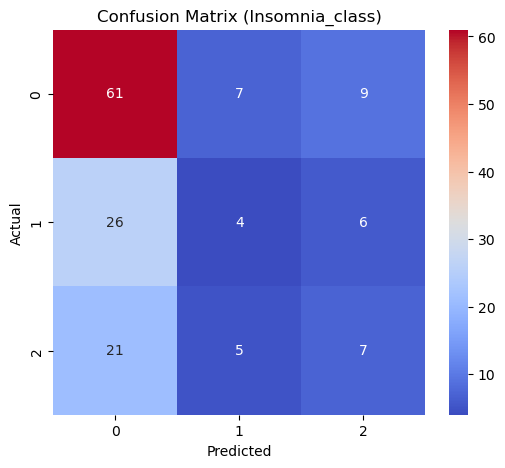

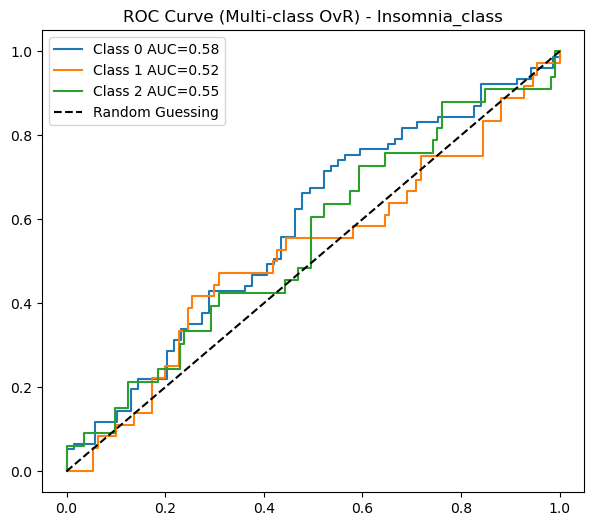

[I 2025-11-30 23:38:04,545] A new study created in memory with name: no-name-bc80b3e9-98c4-4a8b-8e26-90c92003dfd7


Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_insomnia_model.pkl


[I 2025-11-30 23:38:05,015] Trial 0 finished with value: 0.29729515943690665 and parameters: {'n_estimators': 114, 'learning_rate': 0.019297223403091673, 'max_depth': 4, 'subsample': 0.9858079198240107, 'colsample_bytree': 0.7198401966143171, 'gamma': 0.44762527349528636, 'min_child_weight': 2}. Best is trial 0 with value: 0.29729515943690665.
[I 2025-11-30 23:38:06,226] Trial 1 finished with value: 0.29722047530374357 and parameters: {'n_estimators': 244, 'learning_rate': 0.0263328906443408, 'max_depth': 8, 'subsample': 0.7154946935690958, 'colsample_bytree': 0.6834466001113902, 'gamma': 0.02286872088766656, 'min_child_weight': 3}. Best is trial 0 with value: 0.29729515943690665.
[I 2025-11-30 23:38:06,788] Trial 2 finished with value: 0.26940475537488057 and parameters: {'n_estimators': 280, 'learning_rate': 0.12401124565401284, 'max_depth': 6, 'subsample': 0.9459633394583477, 'colsample_bytree': 0.7493016988864801, 'gamma': 1.4784939369607883, 'min_child_weight': 1}. Best is trial 0

Best hyperparameters: {'n_estimators': 340, 'learning_rate': 0.23091397483435971, 'max_depth': 3, 'subsample': 0.8368935447705231, 'colsample_bytree': 0.6916341033437716, 'gamma': 0.3367828224970386, 'min_child_weight': 9}

Evaluation on test set:
Accuracy: 0.5958904109589042
Precision: 0.2619047619047619
Recall: 0.3080246913580247
F1 Score: 0.28036709275647326
ROC AUC: 0.5048829471987918

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.85      0.75       100
           1       0.11      0.07      0.09        27
           2       0.00      0.00      0.00        19

    accuracy                           0.60       146
   macro avg       0.26      0.31      0.28       146
weighted avg       0.48      0.60      0.53       146



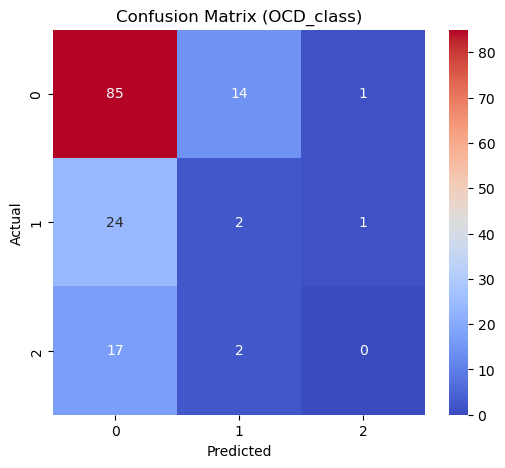

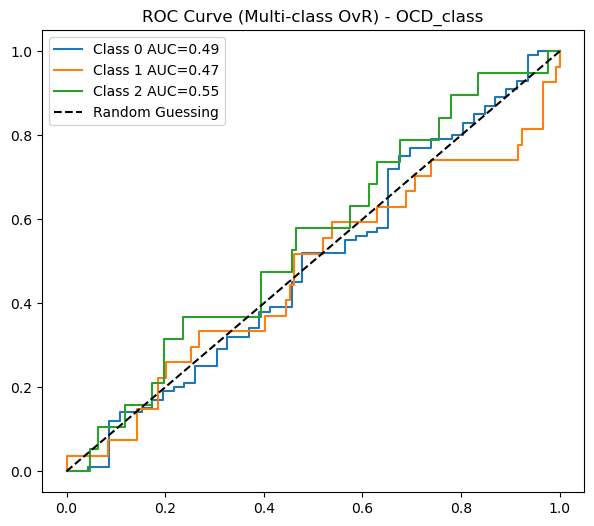

Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_ocd_model.pkl


In [12]:
# Reusable training + tuning function for any target (e.g., Anxiety_class, Depression_class, Insomnia_class, OCD_class)
import optuna
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize

def train_and_eval(target_col, n_trials=50, random_state=42):
    """Run Optuna hyperparameter tuning for XGBClassifier, fit final model, evaluate and save it."""
    if target_col not in df_fe1.columns:
        raise KeyError(f"Target column '{target_col}' not found in dataframe.")

    exclude_cols = [c for c in df_fe1.columns if c.endswith('_class')]
    X = df_fe1.copy().drop(columns=exclude_cols)
    y = df_fe1[target_col].copy()

    

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # Preprocessor (numeric features pipeline)
    num_features = X_train.columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("impute", SimpleImputer(strategy="median")),
                ("scale", StandardScaler())
            ]), num_features)
        ]
    )

    # Optuna objective
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 400),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "objective": "multi:softprob",
            "eval_metric": "mlogloss",
            "tree_method": "hist",
            "random_state": random_state,
            "n_jobs": 1
        }

        model = XGBClassifier(**params)
        pipe = Pipeline([("prep", preprocessor), ("model", model)])

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        scores = []
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            pipe.fit(X_tr, y_tr)
            preds = pipe.predict(X_val)
            score = f1_score(y_val, preds, average="macro")
            scores.append(score)
        return np.mean(scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)


    print("Best hyperparameters:", study.best_params)

    # Train final model with best params on full training set
    best_params = study.best_params
    final_model = XGBClassifier(**best_params, objective="multi:softprob", eval_metric="mlogloss", tree_method="hist", random_state=random_state, n_jobs=-1)
    final_pipe = Pipeline([("prep", preprocessor), ("model", final_model)])
    final_pipe.fit(X_train, y_train)

    # Evaluate on test set
    preds = final_pipe.predict(X_test)
    proba = final_pipe.predict_proba(X_test)

    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average="macro")
    recall = recall_score(y_test, preds, average="macro")
    f1 = f1_score(y_test, preds, average="macro")
    try:
        roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), proba, average="macro", multi_class="ovr")
    except Exception:
        roc_auc = None

    print("\nEvaluation on test set:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    if roc_auc is not None:
        print("ROC AUC:", roc_auc)
    print("\nClassification report:")
    print(classification_report(y_test, preds))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({target_col})")
    plt.show()

    # Plot ROC curves if available
    if roc_auc is not None:
        plt.figure(figsize=(7,6))
        y_bin = label_binarize(y_test, classes=np.unique(y_train))
        for i in range(proba.shape[1]):
            fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
            plt.plot(fpr, tpr, label=f"Class {i} AUC={auc(fpr,tpr):.2f}")
        plt.plot([0,1], [0,1], 'k--', label='Random Guessing')
        plt.legend()
        plt.title(f"ROC Curve (Multi-class OvR) - {target_col}")
        plt.show()

    # Save model
    safe_name = target_col.replace('_class','').lower()
    model_path = os.path.join(os.path.dirname(current_dir), 'models', f'xgboost_{safe_name}_model.pkl')
    joblib.dump(final_pipe, model_path)
    print("Saved model to:", model_path)

    return {"target": target_col, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc, "model_path": model_path}

# Run for both Anxiety and Depression (if available)
results = {}
for target in ['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']:
    if target in df_fe1.columns:
        results[target] = train_and_eval(target, n_trials=30)
    else:
        print(f"Skipping {target}: column not present")

# Print summary
#import json
#print('\nSummary results:')
#print(json.dumps(results, indent=2, default=str))

In [41]:
from FindingBestProfile import MusicProfileOptimiser

# Resolve model file paths relative to the project root (parent of current working dir)
project_root = os.path.dirname(current_dir)
model_paths = {
    'anxiety': os.path.join(project_root, 'models', 'xgboost_anxiety_model.pkl'),
    'depression': os.path.join(project_root, 'models', 'xgboost_depression_model.pkl'),
    'insomnia': os.path.join(project_root, 'models', 'xgboost_insomnia_model.pkl'),
    'ocd': os.path.join(project_root, 'models', 'xgboost_ocd_model.pkl'),
}

# Display the keys of the model paths dictionary
print("Paths for:", model_paths.keys())

Paths for: dict_keys(['anxiety', 'depression', 'insomnia', 'ocd'])


In [43]:
# Initialise optimiser for 'anxiety' condition
optimiser = MusicProfileOptimiser(df_fe1, model_paths, condition='anxiety')
user_row = df_fe1.iloc[7]
user_profile = user_row
result = optimiser.run(user_profile.to_dict()) # Run optimisation


[I 2025-12-01 00:16:47,600] A new study created in memory with name: no-name-97778097-6e51-457e-aef6-11dbdcf60783
[I 2025-12-01 00:16:47,615] Trial 0 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47,630] Trial 1 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47,642] Trial 2 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47,654] Trial 3 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47,667] Trial 4 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47,679] Trial 5 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47

Loaded XGBoost model from: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_anxiety_model.pkl


[I 2025-12-01 00:16:47,800] Trial 15 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47,812] Trial 16 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47,826] Trial 17 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47,843] Trial 18 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47,856] Trial 19 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47,868] Trial 20 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.7357486486434937.
[I 2025-12-01 00:16:47,879] Trial 21 finished with value: 0.7357486486434937 and parameters: {}. Best is trial 0 with value: 0.735

In [40]:
result

{'original_score': 0.6763927340507507,
 'improved_score': 0.6763927340507507,
 'try_more': [],
 'avoid': [],
 'optimised_profile': {'Hours per day': 3.0,
  'While working': 1,
  'Instrumentalist': 1,
  'Composer': 1,
  'Foreign languages': 0,
  'Frequency [Classical]': 1.0,
  'Frequency [Country]': 1.0,
  'Frequency [EDM]': 5.0,
  'Frequency [Folk]': 2.0,
  'Frequency [Hip hop]': 2.0,
  'Frequency [Jazz]': 1.0,
  'Frequency [K pop]': 0.0,
  'Frequency [Latin]': 0.0,
  'Frequency [Lofi]': 1.0,
  'Frequency [Metal]': 2.0,
  'Frequency [Pop]': 2.0,
  'Frequency [R&B]': 2.0,
  'Frequency [Rap]': 2.0,
  'Frequency [Rock]': 4.0,
  'Frequency [Video game music]': 4.0,
  'Anxiety_class': 1,
  'Depression_class': 1,
  'Insomnia_class': 0,
  'OCD_class': 0,
  'AgeGroup_<18': False,
  'AgeGroup_18-24': True,
  'AgeGroup_25-34': False,
  'AgeGroup_35-44': False,
  'AgeGroup_45-54': False,
  'AgeGroup_55-64': False,
  'AgeGroup_65+': False}}

In [31]:
optimiser = MusicProfileOptimiser(df_fe1, model_paths, condition='anxiety')
user_profile = df_fe1.iloc[0]
result = optimiser.run(user_profile.to_dict(), n_calls=50) # Run optimisation
result








[I 2025-12-01 00:04:09,655] A new study created in memory with name: no-name-4077e9b9-1ad2-43bf-a5a0-3dd66568af54
[I 2025-12-01 00:04:09,669] Trial 0 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,683] Trial 1 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,698] Trial 2 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,712] Trial 3 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,724] Trial 4 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,739] Trial 5 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,753] Trial 6 finished w

Loaded XGBoost model from: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_anxiety_model.pkl


[I 2025-12-01 00:04:09,859] Trial 14 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,872] Trial 15 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,888] Trial 16 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,904] Trial 17 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,918] Trial 18 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,932] Trial 19 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01 00:04:09,947] Trial 20 finished with value: 0.74695885181427 and parameters: {}. Best is trial 0 with value: 0.74695885181427.
[I 2025-12-01

{'original_score': 0.74695885181427,
 'improved_score': 0.74695885181427,
 'try_more': [],
 'avoid': [],
 'optimised_profile': {'Hours per day': 3.0,
  'While working': 1,
  'Instrumentalist': 1,
  'Composer': 1,
  'Foreign languages': 1,
  'Frequency [Classical]': 1.0,
  'Frequency [Country]': 0.0,
  'Frequency [EDM]': 1.0,
  'Frequency [Folk]': 0.0,
  'Frequency [Hip hop]': 2.0,
  'Frequency [Jazz]': 0.0,
  'Frequency [K pop]': 4.0,
  'Frequency [Latin]': 5.0,
  'Frequency [Lofi]': 1.0,
  'Frequency [Metal]': 0.0,
  'Frequency [Pop]': 4.0,
  'Frequency [R&B]': 2.0,
  'Frequency [Rap]': 4.0,
  'Frequency [Rock]': 0.0,
  'Frequency [Video game music]': 2.0,
  'Anxiety_class': 0,
  'Depression_class': 0,
  'Insomnia_class': 0,
  'OCD_class': 0,
  'AgeGroup_<18': False,
  'AgeGroup_18-24': True,
  'AgeGroup_25-34': False,
  'AgeGroup_35-44': False,
  'AgeGroup_45-54': False,
  'AgeGroup_55-64': False,
  'AgeGroup_65+': False}}